# Perform Pseudo batch transformation

This tutorial will show how to use the pseodo batch transformation function in python and explain the data structure of the input data.

## Loading fedbatch data
We will start with setting up the python session and loading the data.

In [14]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pseudobatch import pseudobatch_transform_pandas
from pseudobatch.datasets import load_standard_fedbatch

The pseudobatch package includes few datasets of simulated data that are used to showcase the package. We will load the simplest one which is a exponential fed-batch fermentation operated in substrate limited mode.

In [15]:
fedbatch_df = load_standard_fedbatch()

Lets start with getting an overview of the data that we have imported by looking at a part of the dataframe.

In [16]:
(fedbatch_df
    .query('(timestamp > 9.7) & (timestamp < 10.2)')
    .filter(['sample_volume', 'timestamp', 'c_Biomass', 'c_Glucose', 'c_Product', 'v_Volume', 'v_Feed_accum'])
)

,sample_volume,timestamp,c_Biomass,c_Glucose,c_Product,v_Volume,v_Feed_accum
162,0.0,9.72973,1.303037,0.075020,0.665867,1015.235064,15.235064
163,0.0,9.78979,1.310697,0.075018,0.672219,1015.382606,15.382606
164,0.0,9.84985,1.318401,0.075016,0.678607,1015.531036,15.531036
165,0.0,9.90991,1.326149,0.075014,0.685031,1015.680361,15.680361
166,0.0,9.96997,1.333942,0.075013,0.691493,1015.830585,15.830585
167,100.0,10.00000,1.337854,0.075012,0.694737,1015.906036,15.906036
168,0.0,10.03003,1.341779,0.075011,0.697991,915.974265,15.974265
169,0.0,10.09009,1.349662,0.075007,0.704528,916.111339,16.111339
170,0.0,10.15015,1.357591,0.075001,0.711103,916.249238,16.249238


This shows some of the columns in the dataframe. 
- `sample_volume` columns contain the sample volume at the given time point. In this dataset, we have online measurements thus more measurements than samples and therefore at most timepoint the sample volume is 0.
- `timestamp` describe the timepoint
- `c_Biomass`, `c_Glucose`, and `c_Product` is the online concentration measurements 
- `v_Volume` is the volume of the bioreactor. **IMPORTANT:** at points where a sample is taken this value represents the volume just **before** the sample was drawn.
- `v_Feed_accum` is the accumulated feed added until that timepoint.

This is also the data structure which the `pseudobatch_transform()` expects.
The dataframe does contain more columns that than, what I just showed but these simply contain information about the parameters used for simulation. Some of them, e.g. true maximum growth rate, are typically not know in a real experimental setting and some of them are experimental design parameters, e.g. glucose concentration in the feed. 

Now we can transform the data. Here I will use a convenience wrapper function that can be applied directly to a Pandas DataFrame, but under the hood this just loops over a list of columns and calls the `pseudobatch_transform()` on each of them. Apart from the data shown above we need to input the concentration of each species in the feed medium.

In [17]:
conc_in_feed = [0, 100, 0, 0] # [Biomass, Glucose, Product, CO2] in g/L

fedbatch_df[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo", "c_CO2_pseudo"]] = pseudobatch_transform_pandas(
    fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "c_Glucose", "c_Product", "c_CO2"],
    reactor_volume_colname="v_Volume",
    accumulated_feed_colname="v_Feed_accum",
    sample_volume_colname="sample_volume",
    concentration_in_feed=conc_in_feed,
)

Now we have the pseudo-batch transformed data.

In [18]:
fedbatch_df.filter(['timestamp', "c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo"]).head()

,timestamp,c_Biomass_pseudo,c_Glucose_pseudo,c_Product_pseudo
0,0.00000,0.500000,0.075000,0.000000
1,0.06006,0.503012,0.069428,0.002474
2,0.12012,0.506042,0.063822,0.004964
3,0.18018,0.509091,0.058182,0.007468
4,0.24024,0.512157,0.052509,0.009987


We can quickly visualize the data here

Text(0, 0.5, 'Pseudo concentration')

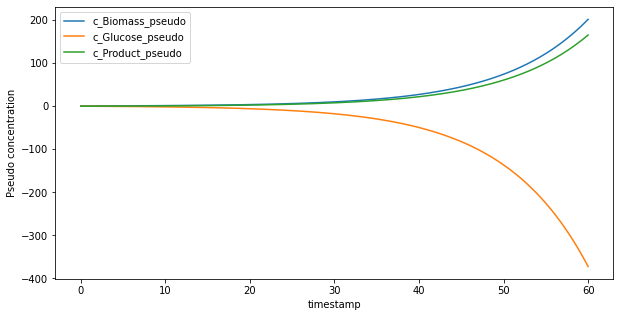

In [30]:
fedbatch_df.plot(x="timestamp", y=["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo"], figsize=(10, 5))
plt.ylabel("Pseudo concentration")

In pseudo batch transformed data consumed species typically becomes negative. This simply shows that the culture have consumed more glucose than was initially present because of the feed. To make a prettier plot we can simply subtract the final pseudo batch concentration from all measurements.

Text(0, 0.5, 'Pseudo concentration')

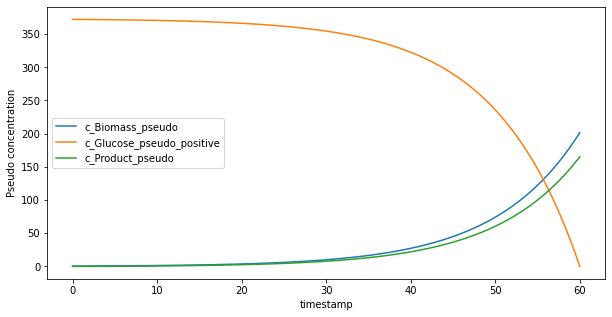

In [29]:
fedbatch_df["c_Glucose_pseudo_positive"] = fedbatch_df["c_Glucose_pseudo"] - fedbatch_df["c_Glucose_pseudo"].iloc[-1]
fedbatch_df.plot(x="timestamp", y=["c_Biomass_pseudo", "c_Glucose_pseudo_positive", "c_Product_pseudo"], figsize=(10, 5))
plt.ylabel("Pseudo concentration")

Now the data also looks more like what we usually expect from a batch culture. Remember that the y-axis has the units pseudo concentration, thus it is difficult to interpret the actual values. It is safest to only interpret time evolution trends of the pseudo batch concentration data.

## Using only measurement data

To make a more realistic example, we will assume that we only have measurements at the sampling time points. Therefore we create a dataframe which contains these measurement data only.

In [21]:
fedbatch_df_measurement = fedbatch_df.query("sample_volume > 0").copy().reset_index(drop=True)

The dataframe that only have measurements at the sampling points, looks as follows:

In [22]:
(fedbatch_df_measurement
    .filter(['sample_volume', 'timestamp', 'c_Biomass', 'c_Glucose', 'c_Product', 'v_Volume', 'v_Feed_accum'])
)

,sample_volume,timestamp,c_Biomass,c_Glucose,c_Product,v_Volume,v_Feed_accum
0,100.0,10.000000,1.337854,0.075012,0.694737,1015.906036,15.906036
1,100.0,14.545455,2.078116,0.075010,1.308552,928.960902,28.960902
2,100.0,19.090909,3.203015,0.075111,2.241303,847.314262,47.314262
3,100.0,23.636364,4.879772,0.075020,3.631646,772.816654,72.816654
4,100.0,28.181818,7.307921,0.075064,5.645033,707.795685,107.795685
5,100.0,32.727273,10.681703,0.075010,8.442525,655.117789,155.117789
6,100.0,37.272727,15.109112,0.075015,12.113671,618.291500,218.291500
7,100.0,41.818182,20.503292,0.075044,16.586449,601.721795,301.721795
8,100.0,46.363636,26.510976,0.075043,21.567936,611.318523,411.318523
9,100.0,50.909091,32.568141,0.075049,26.590453,655.738790,555.738790


The procedure for the pseudo batch transformation is exactly the same

In [23]:
conc_in_feed = [0, 100, 0, 0] # [Biomass, Glucose, Product, CO2] in g/L

fedbatch_df_measurement[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo", "c_CO2_pseudo"]] = pseudobatch_transform_pandas(
    fedbatch_df_measurement,
    measured_concentration_colnames=["c_Biomass", "c_Glucose", "c_Product", "c_CO2"],
    reactor_volume_colname="v_Volume",
    accumulated_feed_colname="v_Feed_accum",
    sample_volume_colname="sample_volume",
    concentration_in_feed=conc_in_feed,
)

<AxesSubplot:xlabel='timestamp'>

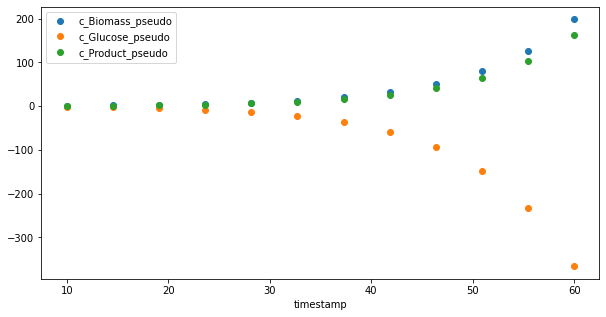

In [24]:
fedbatch_df_measurement.plot(x="timestamp", y=["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo"], figsize=(10, 5), style="o")

This tutorial only shows how to use the pseudo batch transformation. Continue to the next tutorials to see examples of how to integrate the pseudo batch transformation into regular cell cultivation workflows.